# Postprocessing and Dataset Maker (for aggregating SPEED results) (quick thing)
TODO : 
1. postprocessing (make `postprocessing` class or sth)
    * clip/zero if too large 
    * standardization
2. saving dataset_maker (make a h5 saver class or sth)
    * following should be saved : data, lfreq, hfreq, and ch_names and such remember
    * 


In [7]:
import pandas as pd , numpy as np, mne, os 
from glob import glob

### Path 설정 
data_pd_dir = '../dataset_maker/tuh_preproc_related/'

### Preprocessing Parameter 설정 
pretrain_overlap_removal_criteria = 'edf_overlap' #'subject_overlap'  # or 'edf_overlap' depending on the criteria

#pretrain_overlap_removal_criteria 옵션에 따라, df_pretrain (i.e. 전처리하는 dataframe)이 달라집니다. 
if pretrain_overlap_removal_criteria == "subject_overlap" : 
    df_pretrain = pd.read_csv(data_pd_dir + 'tuh_edf_subs_only_in_main.csv')
elif pretrain_overlap_removal_criteria == "edf_overlap" : 
    df_pretrain = pd.read_csv(data_pd_dir + 'tuh_edf_main_only.csv')
elif pretrain_overlap_removal_criteria == "all" : 
    df_pretrain = pd.read_csv(data_pd_dir + 'tuh_edf_complete_distribution.csv')
else : 
    raise ValueError("Proper overlap removal criteria not defined")




#### **things that will be provided** to the class

1. `df_pretrain` : dataframe where the original data names are stored
    * must have `save_method` (same as used during SPEED preprocessing). Only implement for `tueg_fif_ours` for the time being 
    * must have `filename` (to match the name, if `save_method` used was `tueg_fif_ours` during SPEED preprocessing)
    => these two will choose the "SPEED2DF mapper" function or sth (so that the SPEED's result (Path object) can be mapped to the row in df_pretrain)
2. `SPEED_output_path` : path of the `out` folder that holds the SPEED result 
3. `h5_save_path` 
4. `h5_save_format` : for now, just do "LaBraM" 

In [8]:
#arguments
df_pretrain = df_pretrain
save_method = 'tueg_fif_ours' #same as SPEED's yaml file thing (so the mapping is same)
base_path = "/global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/"
SPEED_output_path = os.path.join(base_path, "out")
h5_save_path = os.path.join(base_path, "postprocessing_SPEED")
h5_save_format = "LaBraM" #for now, just use this 


In [9]:
#get the fif files 
fif_paths = glob(os.path.join(SPEED_output_path, '**/*.fif'),recursive=True)


In [ ]:
from typing import Optional, Union
from joblib import Parallel, delayed
import h5py

class BatchPostProcessor:
    def __init__(self, df_pretrain : pd.DataFrame, SPEED_saved_path : str,  h5_save_path : str, 
                 SPEED_saved_method : str = 'tueg_fif_ours', h5_save_method : str = 'LaBraM', 
                 postproc_setting : str = 'LaBraM', n_jobs : int =1):
        self.df_pretrain = df_pretrain
        self.SPEED_saved_path = SPEED_saved_path
        self.h5_save_path = h5_save_path
        self.SPEED_saved_method = SPEED_saved_method
        self.h5_save_method = h5_save_method
        self.postproc_setting = postproc_setting
        self.n_jobs = n_jobs
        
        #setup some stuff
        self.file_list = self.get_file_paths()   
        self.file_list = self.file_list
        self.extreme_value_handle_params, self.normalize_params = self.get_postproc_settings()

    def process_file(self, file_path):
        processor = FilePostProcessingAndSaving(file_path, saved_method=self.SPEED_saved_method, 
                                                extreme_value_handle_params=self.extreme_value_handle_params, normalize_params=self.normalize_params,
                                                h5_save_method=self.h5_save_method, h5_save_path = self.h5_save_path) 
        #!#file_path, saved_method=self.SPEED_saved_method, params={}) #modify params ={} at the end as needed (kwargs)
        processor.load_file()
        processor.np_data, processor.ch_names = processor.load_npy() #by default loads in uV
        processor.postprocess()
        processor.save()
        
        #for checking in between
        # print("0", processor.np_data.shape, processor.np_data.mean(axis=1), processor.np_data.std(axis=1), processor.np_data.min(), processor.np_data.max())
    def run(self):
        Parallel(n_jobs=self.n_jobs)(
            delayed(self.process_file)(file_path) for file_path in self.file_list
        )
    
    
    ###=====METHODS FOR GETTING FIF file list (for creating self.file_list and passing to `run`)=====###    
    def get_file_paths(self): 
        if self.SPEED_saved_method == 'tueg_fif_ours':
            return self._get_file_paths_tueg_fif_ours()
        else:
            raise ValueError("save_method not recognized")
        
    def _get_file_paths_tueg_fif_ours(self):
        fif_paths = glob(os.path.join(self.SPEED_saved_path, '**/*.fif'),recursive=True)
        return fif_paths 
    
    ###=====METHODS FOR SETTING UP POSTPROCESSING SETTINGS=====###
    def get_postproc_settings(self):
        if self.postproc_setting == 'LaBraM':
            extreme_value_handle_params =  {'method' : "absolute_deviation_clip", 'clip_values' : 800}  #{'method' : None} 
            normalize_params = {'method' : None} #{'method' : 'ch_zscore'}
            return extreme_value_handle_params, normalize_params
        else:
            raise ValueError("postproc_setting not recognized")
        
    ###=====METHODS FOR GETTING LABELS (NOT USED FOR NOW, FOR ANGELA)=====###    
    def get_row_from_SPEED(self, fif_path)  :
        #! this was added for future compatibility (df_pretrain is not needed tbh, but for the future when labeled data is needed, from which label should be brought from df_pretrain)
        if self.save_method == 'tueg_fif_ours':
            return self._tueg_fif_ours_mapper(fif_path)
        else:
            raise ValueError("save_method not recognized")        
        
    def _tueg_fif_ours_mapper(self, fif_path):
        r""" 
        maps the fif file to the pretrain dataframe assuming "tueg_fif_ours" method was used for `save_method` in SPEED yaml
        """
        #get the subject id 
        folder_name = fif_path.split('/')[-2]
        window_dix = fif_path.split('/')[-1].split('.')[0]
        
        #get the pretrain dataframe row
        pretrain_row = self.df_pretrain[self.df_pretrain['filename'] == folder_name + '.edf']
        return pretrain_row
    
    ###=====METHODS FOR AGGREGATING ALL RUNS AND SAVING THEM=====###
    def aggregate_all_runs(self):
        if self.h5_save_method == 'LaBraM':
            self._save_all_runs_LaBraM()
        else : 
            raise ValueError("h5_save_method not recognized")

    def _save_all_runs_LaBraM(self, fp32 : bool = True):
        ##getting the path
        final_save_h5_path = Path(os.path.join(self.h5_save_path, '..'))
        final_save_h5_dataset = h5Dataset(final_save_h5_path, 'FINAL_ALL_RUNS')
        
        ##saving to new_path and adding attributes : lfreq, hfreq, rsfreq, self.ch_names
        h5_files_list = glob(os.path.join(self.h5_save_path, '**/*.h5'),recursive=True)
        h5_files2_dataset_namer = lambda path : "-".join(path.split('/')[-2:]).split('.')[0]
        print(Path(self.h5_save_path))
        for SPEED_saved_h5_file in h5_files_list:
            with h5py.File(SPEED_saved_h5_file, 'r') as single_file_dataset:
                single_file_dataset_name = h5_files2_dataset_namer(SPEED_saved_h5_file)
                print(f"processing {single_file_dataset_name}")     
                data, attrs = single_file_dataset['data'][:], dict(single_file_dataset.attrs)
                data = data.astype(np.float32) if fp32 else data                
                chOrder_renamed = [ch.upper() for ch in attrs['chOrder']]
                chunk_size = (data.shape[0]//2, attrs['rsFreq'])  #ex : (30, 200) (30 channels, 200 samples)
                                
                #creating and saving the dataset as a group to the final h5 file
                grp = final_save_h5_dataset.addGroup(grpName = single_file_dataset_name)
                single_h5_dataset = final_save_h5_dataset.addDataset(grp, dsName = 'eeg', arr = data, chunks = chunk_size)
                
                #dataset attributes
                final_save_h5_dataset.addAttributes(single_h5_dataset, 'lFreq', attrs['lFreq'])
                final_save_h5_dataset.addAttributes(single_h5_dataset, 'hFreq', attrs['hFreq'])
                final_save_h5_dataset.addAttributes(single_h5_dataset, 'rsFreq', attrs['rsFreq'])
                final_save_h5_dataset.addAttributes(single_h5_dataset, 'chOrder', chOrder_renamed)  
                attrs_not_in_above = {k : v for k,v in attrs.items() if k not in ['lFreq', 'hFreq', 'rsFreq', 'chOrder']}
                for attr_name, attr_value in attrs_not_in_above.items():
                    final_save_h5_dataset.addAttributes(single_h5_dataset, attr_name, attr_value)     
        final_save_h5_dataset.save()

class FilePostProcessingAndSaving:
    def __init__(self, fif_path, saved_method : str, 
                 extreme_value_handle_params : dict, normalize_params : dict,
                 h5_save_method : str = 'LaBraM', h5_save_path : str = None):
        self.fif_path = fif_path
        self.saved_method = saved_method
        self.extreme_value_handle_params = extreme_value_handle_params
        self.normalize_params = normalize_params
        self.h5_save_method = h5_save_method
        self.h5_save_path = h5_save_path
        
    ###=====METHODS FOR LOADING FILE/NPY=====###
    def load_file(self):
        if self.saved_method == 'tueg_fif_ours':
            self.raw = self._load_file_tueg_fif_ours()
        else:
            raise ValueError("save_method not recognized")
    
    def _load_file_tueg_fif_ours(self):
        return mne.io.read_raw_fif(self.fif_path, preload=True)

    def load_npy(self, unit : str = 'uV'):
        return self.raw.get_data(units=unit), self.raw.info['ch_names']
    
    ###=====METHODS FOR POSTPROCESSING=====###
    def postprocess(self):
        self.handle_extreme_values(**self.extreme_value_handle_params) ##ex : {'clip_method' : 'absolute_deviation_clip', 'clip_values' : 3}
        self.normalize_data(**self.normalize_params) ##ex : {'method' : 'ch_zscore'}
        
    def handle_extreme_values(self, method : str = None, clip_values = None): 
        if method is None :
            return
        elif method == "absolute_deviation_clip" : 
            self.np_data = np.clip(self.np_data, -clip_values, clip_values) #! must be tested
        elif method == "absolute_deviation_replace" :
            self.np_data = np.where(np.abs(self.np_data) > clip_values, np.nan, self.np_data) #! must be tested
        elif method == "zscore_clip" :
            raise NotImplementedError("Not implemented yet")
        elif method == "zscore_replace" :
            raise NotImplementedError("Not implemented yet")
        elif method == "minmax_clip" :
            #! TODO : for Angela : might be better if you clip_values as a dict that specifiecs the percentiles and what to replace with and such... 
            raise NotImplementedError("Not implemented yet")        
        elif method == "minmax_replace" :
            raise NotImplementedError("Not implemented yet")
        else :
            raise ValueError(f"{method} not recognized")

    def normalize_data(self, method : str = None):
        if method is None :
            return
        elif method == "demean" :
            self.np_data = self.np_data - np.mean(self.np_data, axis=1, keepdims=True)
        elif method == 'ch_zscore' :
            self.np_data = (self.np_data - np.mean(self.np_data, axis=1, keepdims=True)) / np.std(self.np_data, axis=1, keepdims=True)
        elif method == 'ch_minmax' :
            raise NotImplementedError("Not implemented yet")
        elif method == 'laura' :
            #! TODO : Angela, implement this!
            raise NotImplementedError("Not implemented yet")
    
    ###=====METHODS FOR SAVING=====###
    def save(self):
        if (self.h5_save_method == 'LaBraM') and (self.saved_method == 'tueg_fif_ours'):
            self._save_LaBraM()
        else:
            raise ValueError("h5_save_method not recognized")
    
    def _save_LaBraM(self):
        ##getting the path
        convert_to_h5 = lambda path: "/".join(path.split('/')[-2:]).replace('.fif', '.h5')
        new_path = os.path.join(self.h5_save_path, convert_to_h5(self.fif_path))
        
        os.makedirs(os.path.dirname(new_path), exist_ok=True)

        ##saving to new_path and adding attributes : lfreq, hfreq, rsfreq, self.ch_names
        with h5py.File(new_path, 'w') as f:
                f.create_dataset('data', data=self.np_data)
                f.attrs['lFreq'] = self.raw.info['lowpass']
                f.attrs['hFreq'] = self.raw.info['highpass']
                f.attrs['rsFreq'] = self.raw.info['sfreq']
                f.attrs['chOrder'] = self.ch_names
                f.attrs['time_idx'] = eval(self.raw.info['description'])['time_idx']

###HDF5 AGGREGATE SAVER
#do below (look at make_h5dataset_for_pretrain.py)
            
import h5py
import numpy as np
from pathlib import Path

class h5Dataset:
    def __init__(self, path:Path, name:str) -> None:
        self.__name = name
        self.__f = h5py.File(path / f'{name}.hdf5', 'a')
    
    def addGroup(self, grpName:str):
        return self.__f.create_group(grpName)
    
    def addDataset(self, grp:h5py.Group, dsName:str, arr:np.array, chunks:tuple):
        return grp.create_dataset(dsName, data=arr, chunks=chunks)
    
    def addAttributes(self, src:'h5py.Dataset|h5py.Group', attrName:str, attrValue):
        src.attrs[f'{attrName}'] = attrValue
    
    def save(self):
        self.__f.close()
    
    @property
    def name(self):
        return self.__name


#! get 98 and 80% perf!       
#! make the visualization and comparison stuff!  => #* ASK ANGELA
#! also test if it actually works!
#! option to save all (if so name "ALL") or train/val based on certain percentage provided (if so name "TRAIN" or "VAL")

#!5. PUSH GIT REPO!

#TODO for ANGELA, IN ORDER OF IMPORTANCE
#!1. gain access to nersc (will ask)? => #!2. first get permission to use
#!3. will send small data example to work on 
#!4. visualization and comparison=> DO IT!! 
#!5. implementing preproc for their mehotd
#!7. generalized labeling and saving dataset
#!6. implementing TUEV, TUAB preprocesisng too! 

#! shock utils adjuster? (so that dataloader can be arb length (channel nums) 일단은 그냥 돌리자 ㅋㅋ 
#! or, 그냥 LE, AR 구분해서 edf file저장하고 쓰기 가능...? 


#!아니다 이건 post processing 때 해도 될듯! 일단은 
#! DURING POSTPROCESSING SOMEHOW DIVIDE THE DATA BASED ON THE CHANNEL CONFIG AVAILABLES 
#! (ALSO, MUST REORDER CHANNELS, AS LABRAM EXPECTS ALL CH_ORDER IS SMALL FOR ONE HDF5 DATASET!),  
#* HAVE YAML WHERE  CHANNEL CONFIG IS FIXED! 
#* i.e. EACH HDF5 FILE SHOULD HAVE FIXED CHANNEL CONFIG! 
#* or, use zero filling for missing channels (and keep all the channels?) => do this at post processing!

In [11]:
#testing 
processor = BatchPostProcessor(df_pretrain, SPEED_output_path, h5_save_path, save_method, h5_save_format, n_jobs=1)
processor.run()
processor.aggregate_all_runs()


# os.listdir(processor.h5_save_path)
processor.h5_save_path




Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/out/aaaaaaah_s002_t000/2_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/out/aaaaaaah_s002_t000/3_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/out/aaaaaaah_s002_t000/12_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/out/aaaaaaah_s002_t000/11_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_result

Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/out/aaaaaaaq_s006_t000/23_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/out/aaaaaaaq_s006_t000/31_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/out/aaaaaaaq_s006_t000/30_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/out/aaaaaaaq_s006_t000/2_eeg.fif...
    Range : 0 ... 11999 =      0.000 ...    59.995 secs
Ready.
Reading 0 ... 11999  =      0.000 ...    59.995 secs...
Opening raw data file /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_resul

'/global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_results/postprocessing_SPEED'

In [6]:
import os 

In [50]:
#test if get_row_from_SPEED works
pp = PostProcessingAndSaving(df_pretrain, SPEED_output_path, h5_save_path, save_method, h5_save_format)
row = pp.get_row_from_SPEED(fif_paths[0])
row


NameError: name 'PostProcessingAndSaving' is not defined

In [ ]:
df_pretrain['filename']

0        aaaaakee_s001_t000.edf
1        aaaaakfb_s001_t001.edf
2        aaaaakbs_s001_t001.edf
3        aaaaakbs_s001_t002.edf
4        aaaaakdt_s001_t001.edf
                  ...          
57925    aaaaarux_s003_t004.edf
57926    aaaaarux_s003_t007.edf
57927    aaaaarux_s003_t008.edf
57928    aaaaarux_s001_t000.edf
57929    aaaaaruo_s001_t000.edf
Name: filename, Length: 57930, dtype: object

In [51]:
df_pretrain

,filename,full_path,source_dataset,montage,sub,in_tuh_eeg,in_tuh_eeg_abnormal,in_tuh_eeg_artifact,in_tuh_eeg_epilepsy,in_tuh_eeg_events,in_tuh_eeg_seizure,in_tuh_eeg_slowing,in_tuh_eeg_software,dataset_count,only_in_main,only_in_subdatasets,subs_only_in_main
0,aaaaakee_s001_t000.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,02_tcp_le,aaaaakee,True,False,False,False,False,False,False,False,1,True,False,True
1,aaaaakfb_s001_t001.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaakfb,True,False,False,False,False,False,False,False,1,True,False,True
2,aaaaakbs_s001_t001.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,02_tcp_le,aaaaakbs,True,False,False,False,False,False,False,False,1,True,False,True
3,aaaaakbs_s001_t002.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,02_tcp_le,aaaaakbs,True,False,False,False,False,False,False,False,1,True,False,True
4,aaaaakdt_s001_t001.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaakdt,True,False,False,False,False,False,False,False,1,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57925,aaaaarux_s003_t004.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaarux,True,False,False,False,False,False,False,False,1,True,False,True
57926,aaaaarux_s003_t007.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaarux,True,False,False,False,False,False,False,False,1,True,False,True
57927,aaaaarux_s003_t008.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaarux,True,False,False,False,False,False,False,False,1,True,False,True
57928,aaaaarux_s001_t000.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaarux,True,False,False,False,False,False,False,False,1,True,False,True


In [ ]:
class PostProcessingAndSaving:
    def __init__(self, df_pretrain,  SPEED_output_path, h5_save_path,
                 save_method : str = 'tueg_fif_ours', h5_save_format : str = 'LaBraM'):
        self.df_pretrain = df_pretrain
        self.save_method = save_method
        self.SPEED_output_path = SPEED_output_path
        self.h5_save_path = h5_save_path
        self.h5_save_format = h5_save_format
        
        #setting some stuff up
        self.fif_paths = glob(os.path.join(SPEED_output_path, '**/*.fif'), recursive=True)

        
        #example of usage : 
        #get_row_from_SPEED(fif_paths[0]) #get the corresponding row from df_pretrain for the fif_paths[0] file
        
        
    ###=====METHODS FOR GETTING LABELS (NOT USED FOR NOW, FOR ANGELA)=====###    
    def get_row_from_SPEED(self, fif_path)  :
        #! this was added for future compatibility (df_pretrain is not needed tbh, but for the future when labeled data is needed, from which label should be brought from df_pretrain)
        if self.save_method == 'tueg_fif_ours':
            return self._tueg_fif_ours_mapper(fif_path)
        else:
            raise ValueError("save_method not recognized")        
        
    def _tueg_fif_ours_mapper(self, fif_path):
        r""" 
        maps the fif file to the pretrain dataframe assuming "tueg_fif_ours" method was used for `save_method` in SPEED yaml
        """
        #get the subject id 
        folder_name = fif_path.split('/')[-2]
        window_dix = fif_path.split('/')[-1].split('.')[0]
        
        #get the pretrain dataframe row
        pretrain_row = self.df_pretrain[self.df_pretrain['filename'] == folder_name + '.edf']
        return pretrain_row
    
    ###=====METHODS FOR POSTPROCESSING=====###
    def adhoc_clip_data(self, **) :
        ... 
    
    
    def normalize_data(self, method : str, units : Optional[str] = None):
        r""" 
        method : 
            * None : no normalization
            * 'ch_zscore' : zscore normalization (channel-wise)
            * 'ch_minmax' : minmax normalization (channel-wise)
            * 'units' : normalize to units (channel-wise) (ex : units = 'uV')
            * 'laura' : Laura's method => #! should be implemetned
        """
        raise NotImplementedError("Not implemented yet")
        if method is None :
            return
        elif method == 'ch_zscore' :
            self.raw = self.raw.apply_function(lambda x : (x - np.mean(x)) / np.std(x))
        elif method == 'ch_minmax' :
            self.raw = self.raw.apply_function(lambda x : (x - np.min(x)) / (np.max(x) - np.min(x)))
        elif method == 'units' :
            #uV 하기! (if specified)
            raise NotImplementedError("Not implemented yet")
            # assert units is not None
            # self.raw = self.raw.apply_function(lambda x : x * units)
    
    ###=====METHODS FOR SAVING=====###
    
    
        
        

In [ ]:
import mne 
import numpy as np
import matplotlib.pyplot as plt


# Load the data
raw = mne.io.read_raw_edf('/global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_TUEG_small_data/aaaaaaau/s001_2006/02_tcp_le/aaaaaaau_s001_t000.edf', preload = True)

raw.info

Extracting EDF parameters from /global/cfs/cdirs/m4673/DIVER_temp/temp_SPEED_TUEG_small_data/aaaaaaau/s001_2006/02_tcp_le/aaaaaaau_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: EEG FP1-LE, EEG FP2-LE, EEG F3-LE, EEG F4-LE, EEG C3-LE, EEG ...
 chs: 41 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2006-01-01 00:00:00 UTC
 nchan: 41
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

In [12]:
df_pretrain

,filename,full_path,source_dataset,montage,sub,in_tuh_eeg,in_tuh_eeg_abnormal,in_tuh_eeg_artifact,in_tuh_eeg_epilepsy,in_tuh_eeg_events,in_tuh_eeg_seizure,in_tuh_eeg_slowing,in_tuh_eeg_software,dataset_count,only_in_main,only_in_subdatasets,subs_only_in_main
0,aaaaakee_s001_t000.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,02_tcp_le,aaaaakee,True,False,False,False,False,False,False,False,1,True,False,True
1,aaaaakfb_s001_t001.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaakfb,True,False,False,False,False,False,False,False,1,True,False,True
2,aaaaakbs_s001_t001.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,02_tcp_le,aaaaakbs,True,False,False,False,False,False,False,False,1,True,False,True
3,aaaaakbs_s001_t002.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,02_tcp_le,aaaaakbs,True,False,False,False,False,False,False,False,1,True,False,True
4,aaaaakdt_s001_t001.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaakdt,True,False,False,False,False,False,False,False,1,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57925,aaaaarux_s003_t004.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaarux,True,False,False,False,False,False,False,False,1,True,False,True
57926,aaaaarux_s003_t007.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaarux,True,False,False,False,False,False,False,False,1,True,False,True
57927,aaaaarux_s003_t008.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaarux,True,False,False,False,False,False,False,False,1,True,False,True
57928,aaaaarux_s001_t000.edf,/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/t...,tuh_eeg,01_tcp_ar,aaaaarux,True,False,False,False,False,False,False,False,1,True,False,True


In [15]:
df_pretrain.iloc[0]["full_path"]

'/global/cfs/cdirs/m4750/DIVER/TUData/tuh_eeg/tuh_eeg/v2.0.1/edf/068/aaaaakee/s001_2010/02_tcp_le/aaaaakee_s001_t000.edf'

In [17]:
import pyprep
noisychannels = pyprep.NoisyChannels(data)        
noisychannels.find_bad_by_SNR()
noisychannels.find_bad_by_correlation()
noisychannels.find_bad_by_deviation()
noisychannels.find_bad_by_hfnoise()
noisychannels.find_bad_by_nan_flat()


noisychannels.get_bads()

Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


['EEG 27-LE',
 'DC3-DC',
 'DC6-DC',
 'EEG EKG-LE',
 'EEG 26-LE',
 'EEG 30-LE',
 'DC5-DC',
 'DC7-DC',
 'EEG OZ-LE',
 'DC2-DC',
 'EEG PG2-LE',
 'DC8-DC',
 'DC4-DC',
 'DC1-DC',
 'EEG PG1-LE',
 'PHOTIC PH']

Setting up high-pass filter at 0.5 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.50 Hz: -6.02 dB



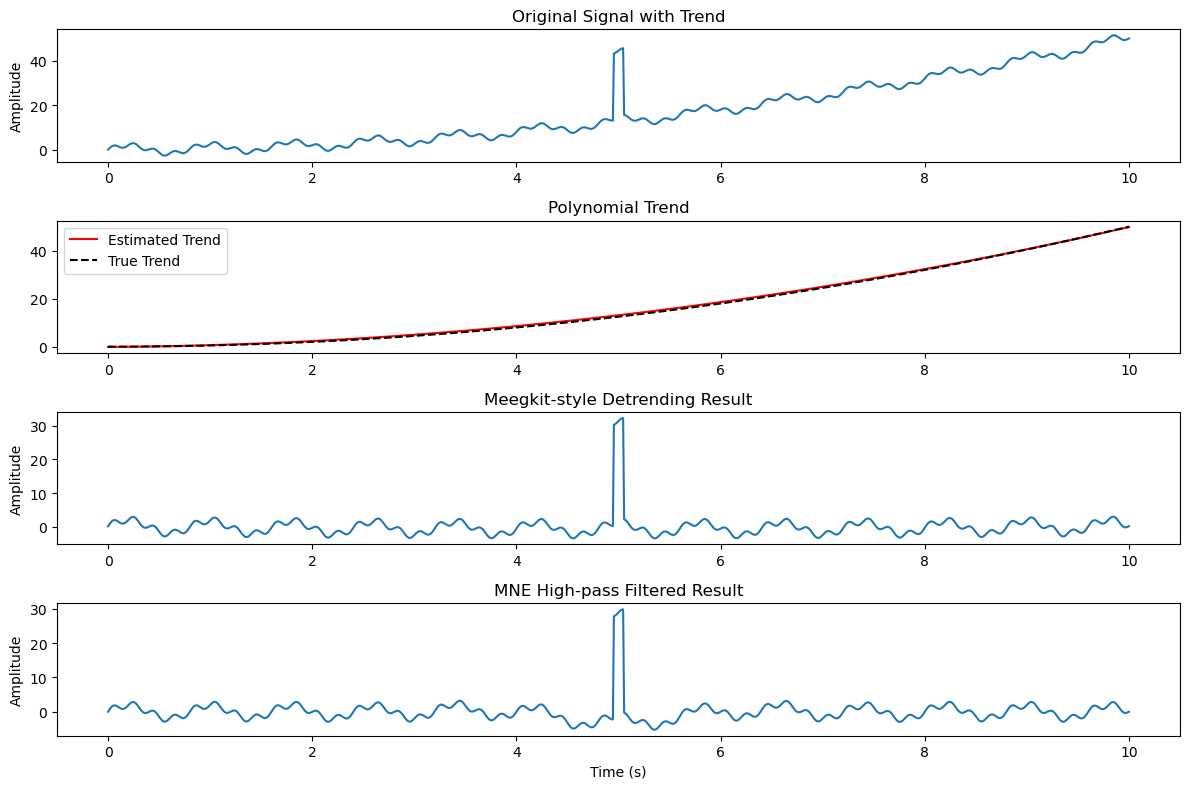

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mne.filter import filter_data
import scipy.signal as signal





# Generate sample data with trend
t = np.linspace(0, 10, 1000)
trend = 0.5 * t**2  # quadratic trend
# Add spike
spike_center = len(t) // 2
spike_width = int(0.05 * sfreq)  # 2 second width in samples
spike = np.zeros_like(t)
spike[spike_center-spike_width:spike_center+spike_width] = 30

signal_freq = 5
pure_signal = np.sin(2 * np.pi * signal_freq * t) + 2*np.sin(0.5 * np.pi * signal_freq * t) 
noisy_signal = pure_signal + trend + spike

# Function to simulate meegkit-style detrending
def polynomial_detrend(x, order=2):
    t = np.arange(len(x))
    p = np.polynomial.polynomial.polyfit(t, x, order)
    trend = np.polynomial.polynomial.polyval(t, p)
    return x - trend, trend

# Apply both methods
# 1. Polynomial detrending (meegkit-style)
detrended_poly, estimated_trend = polynomial_detrend(noisy_signal, order=2)

# 2. MNE highpass filtering
sfreq = len(t) / t[-1]  # sampling frequency
highpass_freq = 0.5  # Hz
filtered_signal = filter_data(noisy_signal, sfreq=sfreq, l_freq=highpass_freq, 
                            h_freq=None, method='iir')

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(t, noisy_signal)
plt.title('Original Signal with Trend')
plt.ylabel('Amplitude')

plt.subplot(412)
plt.plot(t, estimated_trend, 'r', label='Estimated Trend')
plt.plot(t, trend, 'k--', label='True Trend')
plt.title('Polynomial Trend')
plt.legend()

plt.subplot(413)
plt.plot(t, detrended_poly)
plt.title('Meegkit-style Detrending Result')
plt.ylabel('Amplitude')

plt.subplot(414)
plt.plot(t, filtered_signal)
plt.title('MNE High-pass Filtered Result')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()

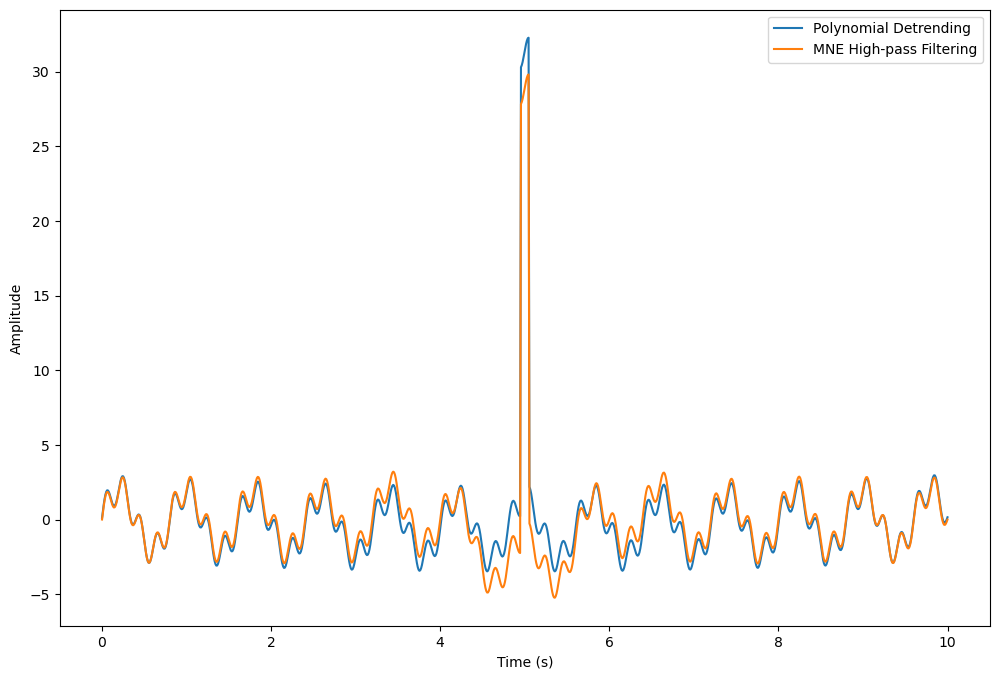

In [21]:
plt.figure(figsize=(12, 8))

plt.plot(t, detrended_poly, label='Polynomial Detrending')
plt.plot(t, filtered_signal, label='MNE High-pass Filtering')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
# plt.xlim(3, 7)
plt.show()